<a href="https://colab.research.google.com/github/Sanamiru/Cuba/blob/main/Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa
!pip install matplotlib
!pip install scipy
!pip install numpy
!pip install soundfile
!pip install Flask
!pip install eel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.2/90.2 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 24.3 MB

Saving example.wav to example (1).wav


<ipython-input-21-17220b940dca>:66: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  reverb_data = audio_data + np.sum(coefficients[i] * delays[i, :] for i in range(len(delay_times)))


<class 'numpy.ndarray'> <class 'int'>
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


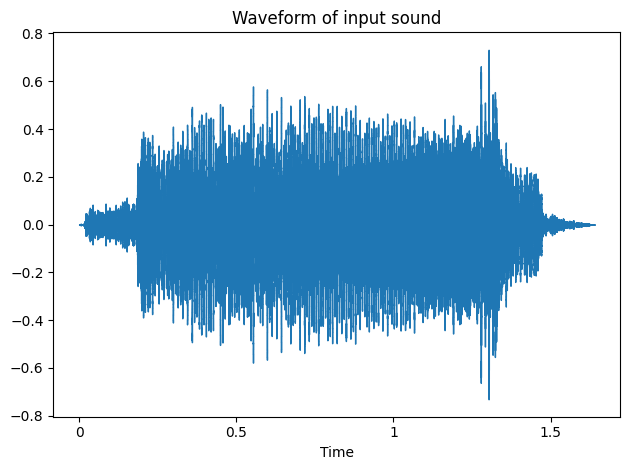

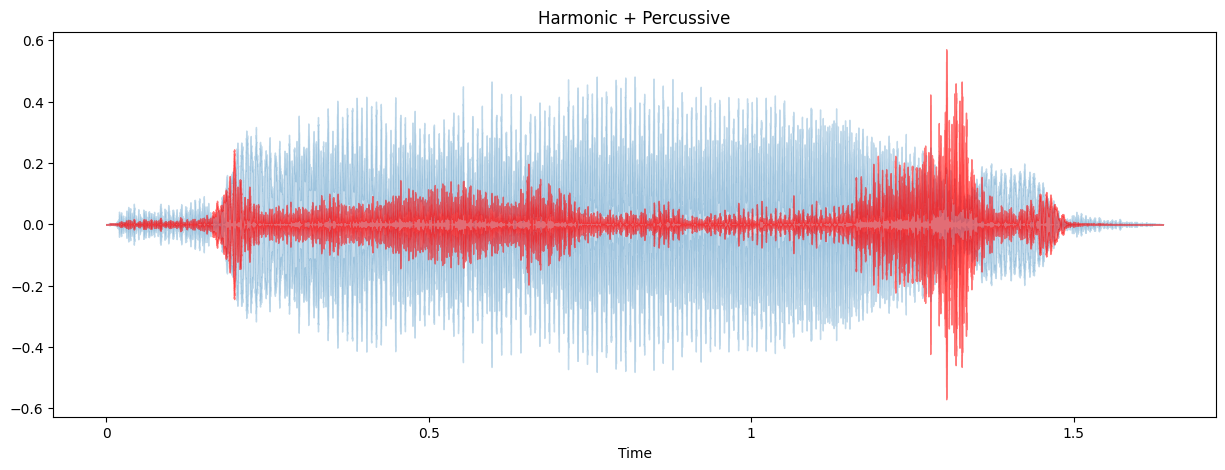

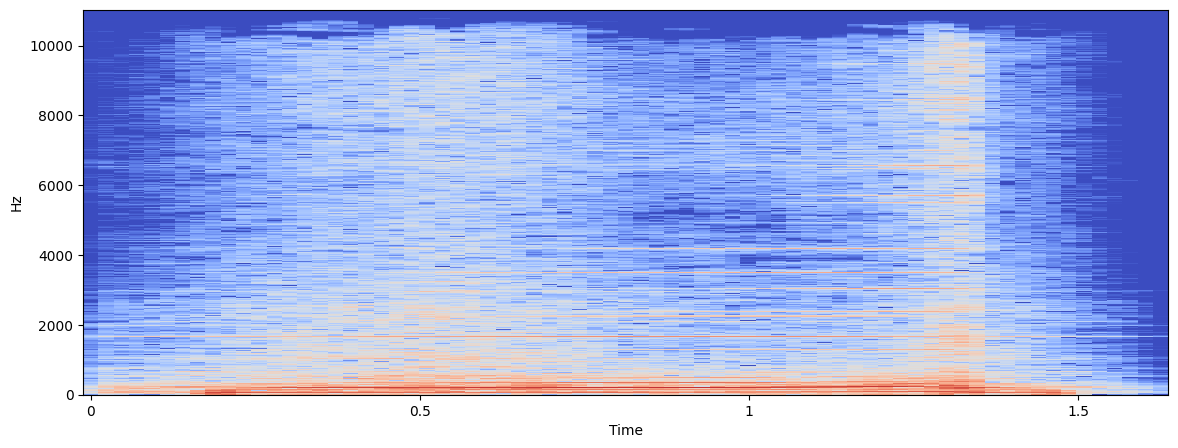

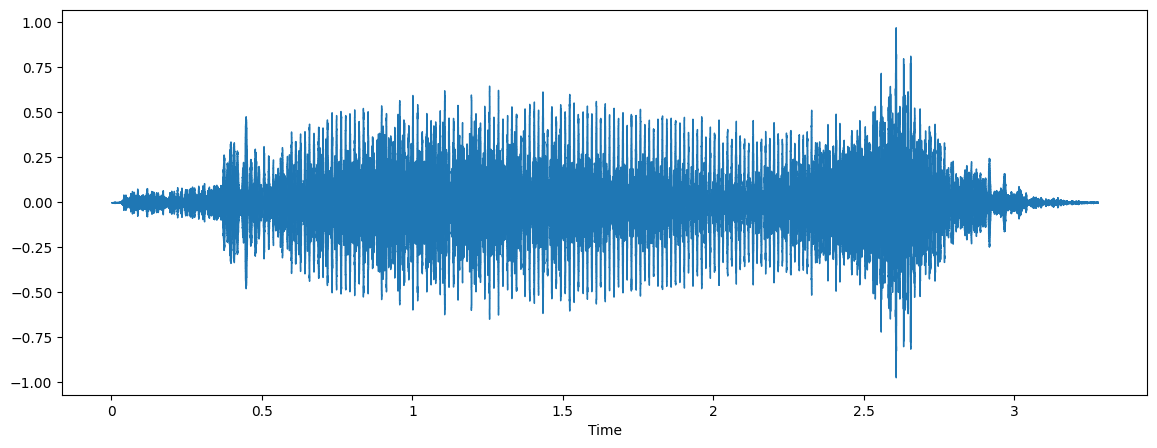

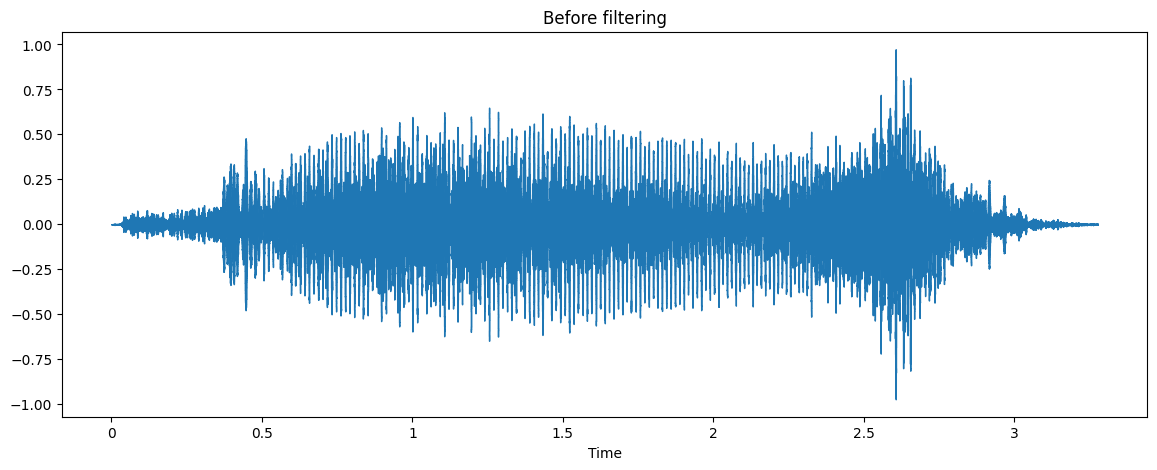

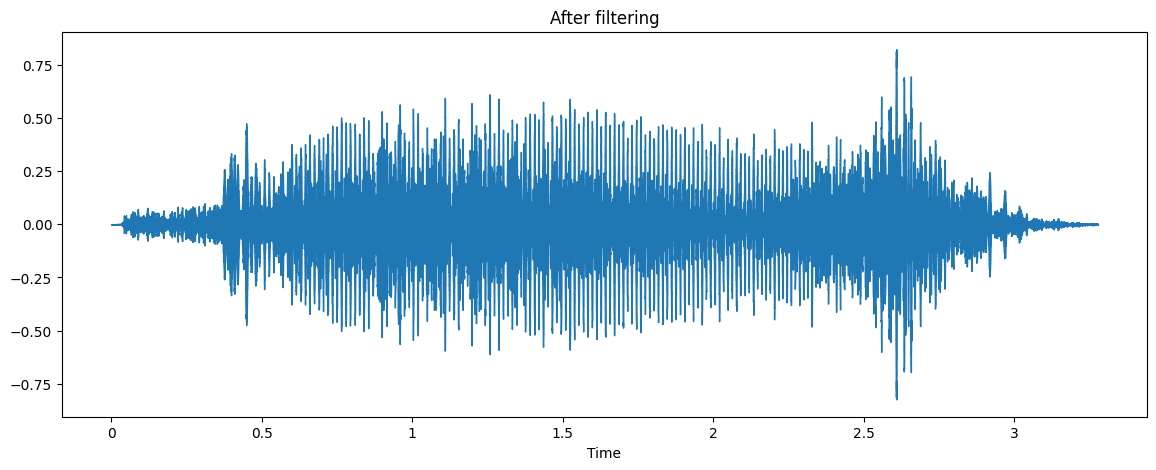

In [21]:
import eel
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter
from scipy.io import wavfile
import numpy as np
import soundfile as sf
from flask import Flask, render_template, request
from google.colab import files
# чтение файла
from google.colab import files
uploaded_file = files.upload()
for name, data in uploaded_file.items():
  with open(name, 'wb') as f:
    f.write(data)
audio_data, sr = librosa.load(list(uploaded_file.keys())[0])


# Предполагая, что загрузка произведена успешно, записываем имя файла в переменную audio_data
audio_data = list(uploaded_file.keys())[0]

# Загружаем аудиофайл и частоту дискретизации
audio_data, sr = librosa.load(audio_data)

# Визуализация графика аудиодорожки
plt.figure()
librosa.display.waveshow(audio_data, sr=sr)
plt.title('Waveform of input sound')
plt.tight_layout()
plt.savefig('input_soundwave.jpg')

#Separation of Hermonic and Percurssive signals
y = audio_data
y_harmonic, y_percussive = librosa.effects.hpss(y)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y_harmonic, sr=sr, alpha=0.25)
librosa.display.waveshow(y_percussive, sr=sr, color='r', alpha=0.5)
plt.title('Harmonic + Percussive')
plt.savefig('input_soundwave Harmonic.jpg')

#spectrum
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.savefig('input_soundwave Spectrum.jpg')

#обработка звука

#reverb

# Загрузка аудиофайла
sample_rate, audio_data = wavfile.read('example.wav')

# Создание задержек
delay_times = [int(sample_rate * t) for t in [0.05, 0.1, 0.15, 0.2]]
audio_data = audio_data.reshape(-1, 1)
delays = np.zeros((len(delay_times), len(audio_data), 1))
for i, delay in enumerate(delay_times):
    delays[i, delay:, :] = audio_data[:-delay, :] 

# Устанавливаем коэффициенты громкости для каждой задержки
coefficients = [0.6, 0.3, 0.1, 0.05]

# Добавляем задержки с коэффициентами громкости
reverb_data = audio_data + np.sum(coefficients[i] * delays[i, :] for i in range(len(delay_times)))

# Нормализация и приведение типа данных
reverb_data = np.int16(reverb_data / np.max(np.abs(reverb_data)) * 32767)

# Запись файла с эффектом реверберации
wavfile.write('reverb_audio.wav', sample_rate, reverb_data)

# Прослушивание файла
y, sr = librosa.load('reverb_audio.wav')
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y,sr=sr)
print(type(y), type(sr))
plt.savefig('reverb_soundwave.jpg')


#низкочастотный фильтр
def apply_filter(audio_data, sample_rate, cutoff_freq):
    # Определите параметры фильтра
    filter_order = 100
    nyquist_freq = sample_rate / 2.0
    cutoff_norm = cutoff_freq / nyquist_freq

    # Создайте фильтр
    fir_coeff = firwin(filter_order, cutoff_norm)

    # Примените фильтр к аудио-данным
    filtered_data = lfilter(fir_coeff, 1.0, audio_data)

    return filtered_data
# график до фильтрации
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Before filtering')
plt.savefig('before_filtering.jpg')

# фильтрация
cutoff_freq=1000
filtered_audio = apply_filter(y, sr, cutoff_freq)

# график после фильтрации
plt.figure(figsize=(14, 5))
librosa.display.waveshow(filtered_audio, sr=sr)
plt.title('After filtering')
plt.savefig('after_filtering.jpg')
# сохранение результата
sf.write('filtered_audio.wav', filtered_audio, sr)

# запуск интерфейса
from flask import Flask, render_template, request
import librosa
import librosa.display
import numpy as np
import soundfile as sf
from scipy.signal import butter, filtfilt

app = Flask(__name__)

# главная страница
@app.route('/')
def index():
    return render_template('main.html')

# обработка POST-запроса
@app.route('/filter', methods=['POST'])
def filter():
    # получение частоты среза из POST-запроса
    cutoff_frequency = request.form['cutoff_frequency']
    cutoff_frequency = float(cutoff_frequency)

    # чтение файла
    audio_data = 'example.wav'
    y, sr = librosa.load(audio_data)

    # фильтрация
    filtered_audio = apply_filter(y, sr, cutoff_frequency)

    # сохранение результата
    sf.write('reverb_audio.wav', reverb_data, sample_rate)
    sf.write('filtered_audio.wav', filtered_data, sample_rate)
    # вывод результата на страницу
    return render_template('filter_result.html')

def butter_lowpass(cutoff, sample_rate, order=5):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_filter(audio_file, sample_rate, cutoff_frequency):
    b, a = butter_lowpass(cutoff_frequency, sample_rate)
    filtered_audio = filtfilt(b, a, audio_file)
    return filtered_audio

if __name__ == '__main__':
    app.run(host='0.0.0.0',port=5000)